# Analysis of Relations Game Experiments
This notebook collects and analyses experiment results that are run on the relations game dataset.

In [1]:
# Collect imports
from typing import Dict
from pprint import pprint
import re
import json
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

import utils.analysis
import utils.clingo

np.set_printoptions(suppress=True, precision=5, linewidth=120)

In [2]:
# Setup mlflow client
mlclient = MlflowClient(tracking_uri="http://localhost:8888") # Emptry string for local
[x.name for x in mlclient.list_experiments()]

['relsgame-recon_dnf-20210429-121731',
 'relsgame-predinet-20210429-121731',
 'relsgame-dnf-20210429-121731']

## Aggregate Experiment Results
We will look at aggregate metric performances of runs in a given experiment.

In [3]:
# Let's collect experiment results
exp_data = ['relsgame-predinet-20210429-121731', 'relsgame-dnf-20210429-121731', 'relsgame-recon_dnf-20210429-121731']

def load_exp_data(exp_name: str):
    """Load experiment data and select common columns."""
    exp_ref = mlclient.get_experiment_by_name(exp_name)
    print(exp_ref)
    common_columns = ['epoch', 'run_id', 'relsgame_train_size', 'relsgame_task_nickname', 'run_count', 'nickname']
    edata = utils.analysis.collect_experiment_data(exp_name, mlclient)
    select_columns = common_columns + edata.columns[edata.columns.str.contains(r'acc|loss')].values.tolist()
    edata = edata[select_columns]
    if 'recon_dnf' in exp_name:
        # Fix column names for reconstruction dnf model
        # We will drop recon loss etc and just focus on the label prediction for comparison
        drop_cols = edata.columns[(~edata.columns.str.contains('nullary') & edata.columns.str.contains(r'acc|loss'))]
        edata.drop(columns=drop_cols, inplace=True)
        # Rename nullary columns to match the rest of the models
        edata.rename(columns={k: k.replace('nullary_', '') for k in edata.columns}, inplace=True)
    edata.reset_index(drop=True, inplace=True)
    return edata

exp_data = pd.concat([load_exp_data(ename) for ename in exp_data])
exp_data.reset_index(drop=True, inplace=True)
assert exp_data.index.is_unique, "Experiment data index must be unique."
exp_data

<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/44', experiment_id='44', lifecycle_stage='active', name='relsgame-predinet-20210429-121731', tags={}>


100%|██████████| 75/75 [00:07<00:00,  9.96it/s]


<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/45', experiment_id='45', lifecycle_stage='active', name='relsgame-dnf-20210429-121731', tags={}>


100%|██████████| 225/225 [00:28<00:00,  7.95it/s]


<Experiment: artifact_location='/homes/nuric/phd/pix2rule/data/artifacts/43', experiment_id='43', lifecycle_stage='active', name='relsgame-recon_dnf-20210429-121731', tags={}>


100%|██████████| 225/225 [00:55<00:00,  4.08it/s]


,epoch,run_id,relsgame_train_size,relsgame_task_nickname,run_count,nickname,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc
0,0.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.688919,0.495764,0.691976,0.506,0.701570,0.510,0.697943,0.512,0.693747,0.498
1,1.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.660302,0.541800,0.720543,0.525,0.719991,0.514,0.724768,0.508,0.725080,0.499
2,2.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.594077,0.639386,0.730499,0.548,0.776410,0.552,0.779543,0.541,0.713224,0.512
3,3.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.485466,0.743914,0.746004,0.549,0.838926,0.528,0.830200,0.560,0.746557,0.549
4,4.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,predinet,0.355022,0.835598,0.846999,0.562,1.041899,0.551,0.984313,0.572,0.905049,0.538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78745,145.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,recon_dnf_image_classifier_hidden,0.006933,0.998500,4.686668,0.521,4.731852,0.502,5.272784,0.494,5.308239,0.518
78746,146.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,recon_dnf_image_classifier_hidden,0.014594,0.996500,4.557562,0.512,4.430469,0.519,4.936508,0.504,4.981717,0.531
78747,147.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,recon_dnf_image_classifier_hidden,0.011812,0.997200,4.562741,0.519,4.359587,0.501,4.813401,0.508,5.269330,0.514
78748,148.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,recon_dnf_image_classifier_hidden,0.012849,0.997300,4.739218,0.521,4.705024,0.507,5.061118,0.501,5.624608,0.525


In [4]:
# Clean up column and model names
def nickname_to_model(nickname: str) -> str:
    """Map model nicknames to abbreviations."""
    if nickname == 'predinet':
        return 'PrediNet'
    mname = 'DNF-'
    if 'hidden' in nickname:
        mname += 'h'
    elif 'recursive' in nickname:
        mname += 'r'
    if nickname.startswith('recon'):
        mname += 'i'
    return mname.rstrip("-")

def clean_up_exp_data(edata: pd.DataFrame) -> pd.DataFrame:
    """Clean up column and model names."""
    edata = edata.assign(model=edata['nickname'].map(nickname_to_model))
    edata.drop(columns=['nickname'], inplace=True)
    edata.rename(columns={'relsgame_train_size': 'train_size', 'relsgame_task_nickname': 'task'}, inplace=True)
    return edata

exp_data = clean_up_exp_data(exp_data)
exp_data

,epoch,run_id,train_size,task,run_count,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc,model
0,0.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.688919,0.495764,0.691976,0.506,0.701570,0.510,0.697943,0.512,0.693747,0.498,PrediNet
1,1.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.660302,0.541800,0.720543,0.525,0.719991,0.514,0.724768,0.508,0.725080,0.499,PrediNet
2,2.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.594077,0.639386,0.730499,0.548,0.776410,0.552,0.779543,0.541,0.713224,0.512,PrediNet
3,3.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.485466,0.743914,0.746004,0.549,0.838926,0.528,0.830200,0.560,0.746557,0.549,PrediNet
4,4.0,ab6f9e2e066944e680a76270ddb08415,1000,xoccurs,3,0.355022,0.835598,0.846999,0.562,1.041899,0.551,0.984313,0.572,0.905049,0.538,PrediNet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78745,145.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,0.006933,0.998500,4.686668,0.521,4.731852,0.502,5.272784,0.494,5.308239,0.518,DNF-hi
78746,146.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,0.014594,0.996500,4.557562,0.512,4.430469,0.519,4.936508,0.504,4.981717,0.531,DNF-hi
78747,147.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,0.011812,0.997200,4.562741,0.519,4.359587,0.501,4.813401,0.508,5.269330,0.514,DNF-hi
78748,148.0,d3c4b95e93e746f99572d00905dec845,100,xoccurs,4,0.012849,0.997300,4.739218,0.521,4.705024,0.507,5.061118,0.501,5.624608,0.525,DNF-hi


In [5]:
# Let's print the name of the models for reference
exp_data['model'].unique()

array(['PrediNet', 'DNF-h', 'DNF-r', 'DNF', 'DNF-i', 'DNF-hi', 'DNF-ri'], dtype=object)

(11250, 16)


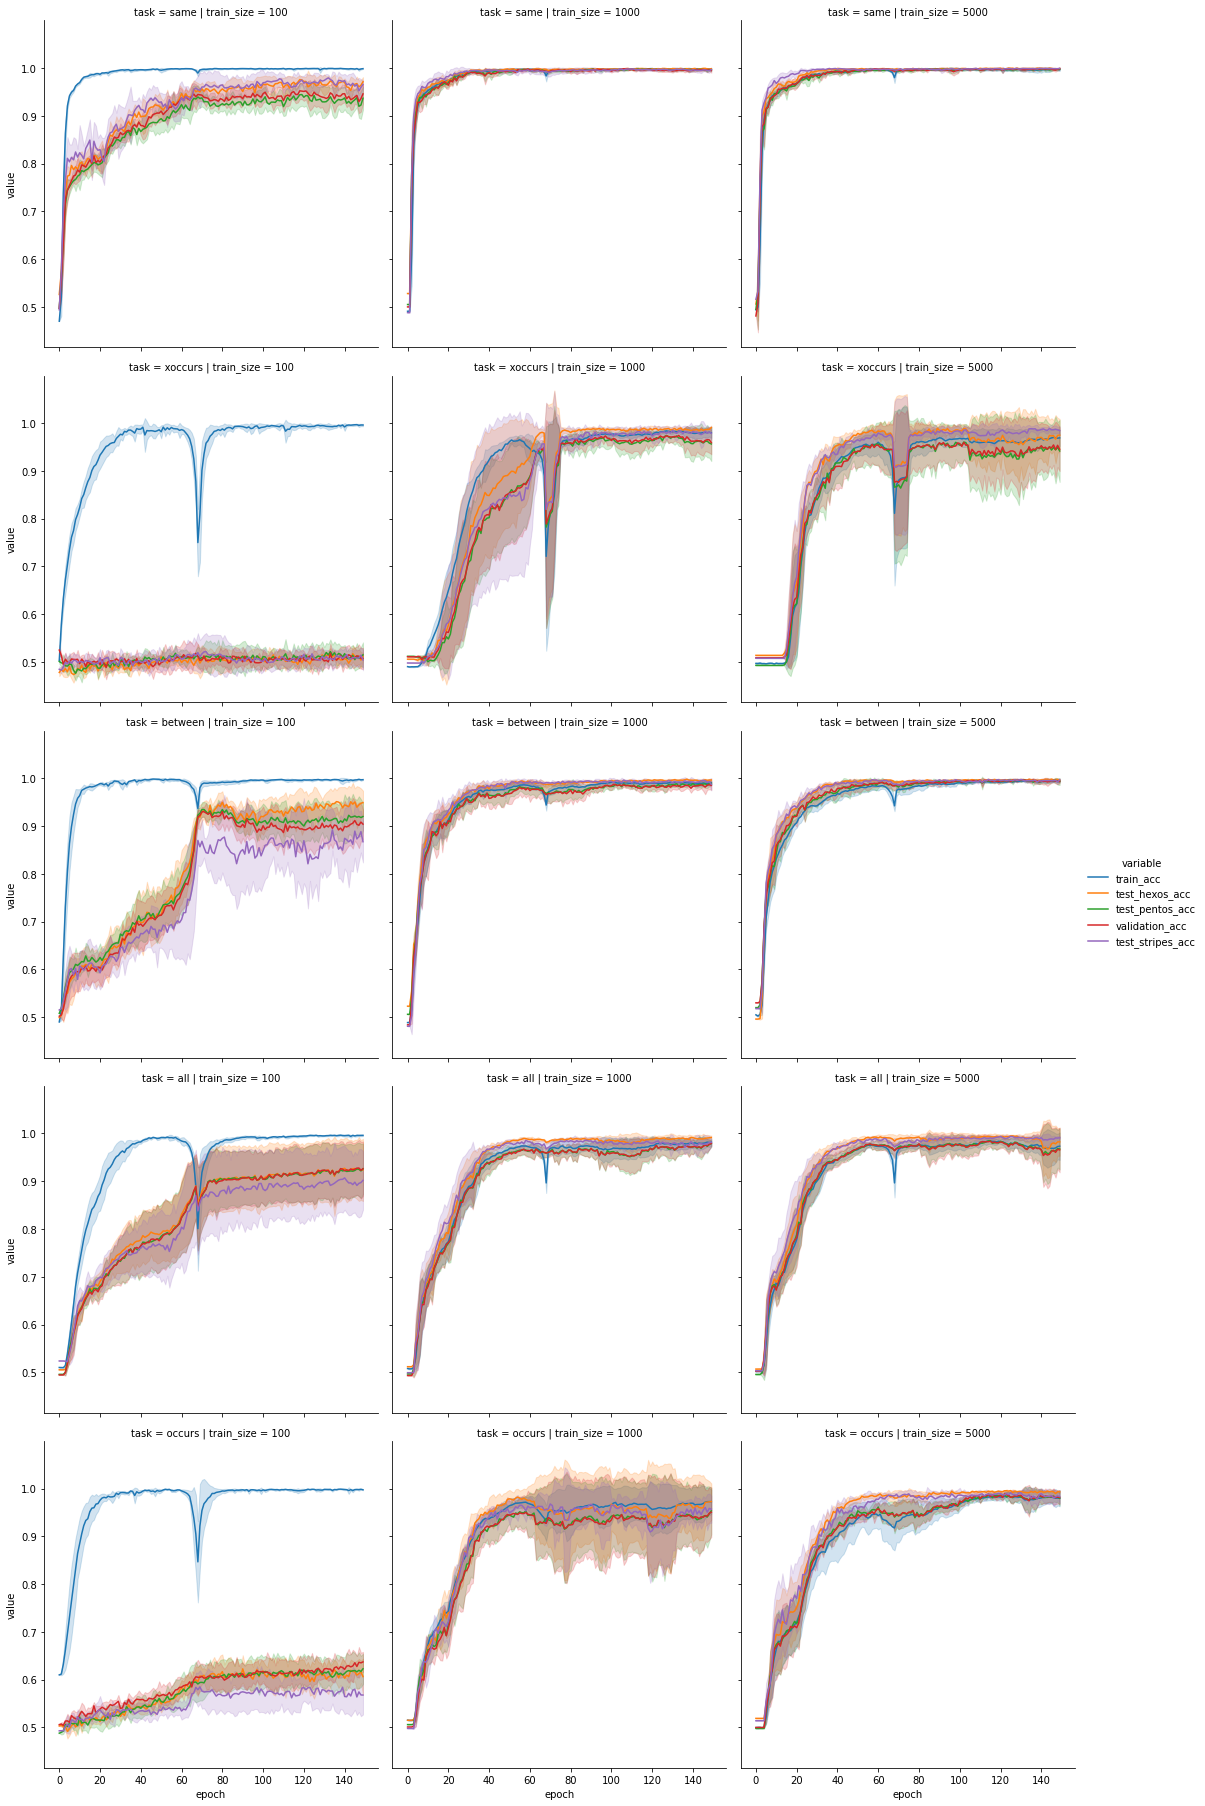

In [6]:
# Plotting the training curves for one of these models
def plot_training_curves(model_name: str, suffix: str = 'acc'):
    """Plot the training curves for a given model in an experiment."""
    edata = exp_data[exp_data['model'] == model_name]
    print(edata.shape)
    assert edata.size, f"Did not find {model_name}."
    fields = edata.columns[edata.columns.str.endswith(suffix)]
    df = edata.melt(id_vars=['epoch', 'task', 'train_size'], value_vars=fields)
    sns.relplot(x='epoch', y='value', hue='variable', kind='line', row='task', col='train_size', ci='sd', data=df)
plot_training_curves('DNF-hi', suffix='acc')

In [7]:
# Collect the pruning information of DNF runs
def load_pruning_infos(edata: pd.DataFrame) -> pd.DataFrame:
    """Load pruning information of runs for a given experiment."""
    pruning_infos = list()
    for run_id in tqdm.tqdm(edata['run_id'].unique()):
        try:
            fpath = mlclient.download_artifacts(run_id, "pruning_info.json")
            with open(fpath) as jsonfile:
                run_json = json.load(jsonfile)
            # We only want the last stage of pruning, if there is a hidden layer, then it will after its and_kernel
            # is threshold_pruned, otherwise it will be dnf_layer.and_kernel.test_--_threshold_pruned_loss etc.
            if 'hidden_dnf_layer.and_kernel.validation_threshold_pruned_loss' in run_json:
                # We have a hidden layer, we take last stage of pruning
                prefix = 'hidden_dnf_layer'
            else:
                # We just want the dnf_layer.and_kernel results
                prefix = 'dnf_layer'
            keys = [k for k in run_json.keys() if k.startswith(prefix+'.and_kernel') and 'threshold_pruned' in k and k.endswith('acc')]
            # Collate into new dictionary
            pruning_info = {k.split('.')[-1].replace('threshold_pruned_', '').replace('nullary_', ''): run_json[k] for k in keys}
            pruning_info['run_id'] = run_id
            pruning_infos.append(pruning_info)
        except OSError as e:
            print("Skipping", run_id, e)
    pruning_pd = pd.DataFrame(pruning_infos).set_index('run_id')
    assert pruning_pd.index.is_unique, f"Pruning data frame has non-unique indices: {pruning_pd.index}"
    return pruning_pd
pruning_data = load_pruning_infos(exp_data[exp_data['model'] != 'PrediNet'])
pruning_data

100%|██████████| 450/450 [00:30<00:00, 14.85it/s]


,test_hexos_acc,test_stripes_acc,test_pentos_acc,validation_acc
run_id,,,,
89744697bfdf4632b0b334932ed4bc3d,0.96025,0.93850,0.9430,0.95100
b7040a0eaed843c08caff5e44e4f3dc8,0.98200,0.97000,0.9750,0.97000
39588c00216b425cbe44df23e970c02e,0.50300,0.49300,0.4880,0.50600
ff69f03a6e214d0597d975fd0653a8b1,0.97200,0.94900,0.9290,0.94200
8df7951d64c6471091d4979eaa01c169,0.50525,0.52375,0.4960,0.49600
...,...,...,...,...
48c2898d20b3414586f0080c9fb14dad,0.50300,0.49300,0.4880,0.50600
d106a4a8f3654a9c9b4879da1291b61c,0.50675,0.50325,0.4955,0.50225
746df5ba8696446ab5d4061a8eb606bb,0.94800,0.87500,0.8870,0.89100


In [8]:
# Take the best point in the run for non-thresholded results and predinet
def take_best_epoch(edata: pd.DataFrame) -> pd.DataFrame:
    """Take the best epoch for each model in the dataframe."""
    # We will take the best validation accuracy as the best point
    best_idxs = edata.groupby(['run_id'])['validation_acc'].idxmax()
    best_data = edata.iloc[best_idxs]
    best_data.set_index('run_id', inplace=True)
    assert best_data.index.is_unique, f"Best data has non-unique run ids: {best_data.index}"
    return best_data

best_data = take_best_epoch(exp_data)
best_data

,epoch,train_size,task,run_count,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc,model
run_id,,,,,,,,,,,,,,,
0008d7c4343f4e5ba5368350cea0fd0e,99.0,5000,xoccurs,4,0.059189,0.976092,0.040868,0.989,0.038792,0.985,0.036406,0.989,0.042219,0.989,DNF-hi
00133416a28e41f6b4c0e580103dda55,88.0,5000,xoccurs,3,0.216789,0.886795,0.093326,0.962,0.195721,0.892,0.186559,0.908,0.132574,0.949,DNF-h
00bc668f03924505ad6f690621838cf0,78.0,1000,same,2,0.018044,0.997522,0.013395,0.999,0.018233,0.997,0.008467,1.000,0.010396,0.999,DNF-h
01157fe902924889bcb366d7470117c4,143.0,5000,xoccurs,4,0.459530,0.710750,0.227540,0.894,0.331437,0.816,0.338766,0.832,0.174913,0.938,DNF
02d1292dbe554b2f9c721f02e5876ce6,85.0,100,same,4,0.007018,0.999400,0.152127,0.970,0.312855,0.926,0.195325,0.956,0.213991,0.963,DNF-h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe5d255a6a5a429081a5b41fc89fdabe,62.0,1000,occurs,4,0.040897,0.984495,0.141266,0.950,0.102567,0.959,0.095183,0.972,0.186693,0.954,PrediNet
fed24c71e04740769178a95525be1b8b,147.0,100,xoccurs,4,0.051761,0.985700,2.428504,0.477,2.281714,0.520,2.291468,0.532,2.124804,0.526,DNF-r
ff0771d850a6495f9b8bf1cbef450a97,61.0,5000,between,0,0.042518,0.984631,0.022120,0.997,0.032416,0.983,0.027239,0.993,0.032627,0.990,PrediNet


In [9]:
# Now merge in the thresholded values
run_metadata = best_data[['train_size', 'task', 'run_count', 'model']]
pruning_with_metadata = pruning_data.join(run_metadata)
pruning_with_metadata['model'] += '+t'
all_data = pd.concat([best_data, pruning_with_metadata])
all_data

,epoch,train_size,task,run_count,train_loss,train_acc,test_hexos_loss,test_hexos_acc,test_pentos_loss,test_pentos_acc,validation_loss,validation_acc,test_stripes_loss,test_stripes_acc,model
run_id,,,,,,,,,,,,,,,
0008d7c4343f4e5ba5368350cea0fd0e,99.0,5000,xoccurs,4,0.059189,0.976092,0.040868,0.98900,0.038792,0.9850,0.036406,0.98900,0.042219,0.98900,DNF-hi
00133416a28e41f6b4c0e580103dda55,88.0,5000,xoccurs,3,0.216789,0.886795,0.093326,0.96200,0.195721,0.8920,0.186559,0.90800,0.132574,0.94900,DNF-h
00bc668f03924505ad6f690621838cf0,78.0,1000,same,2,0.018044,0.997522,0.013395,0.99900,0.018233,0.9970,0.008467,1.00000,0.010396,0.99900,DNF-h
01157fe902924889bcb366d7470117c4,143.0,5000,xoccurs,4,0.459530,0.710750,0.227540,0.89400,0.331437,0.8160,0.338766,0.83200,0.174913,0.93800,DNF
02d1292dbe554b2f9c721f02e5876ce6,85.0,100,same,4,0.007018,0.999400,0.152127,0.97000,0.312855,0.9260,0.195325,0.95600,0.213991,0.96300,DNF-h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48c2898d20b3414586f0080c9fb14dad,NaN,100,occurs,4,NaN,NaN,NaN,0.50300,NaN,0.4880,NaN,0.50600,NaN,0.49300,DNF-hi+t
d106a4a8f3654a9c9b4879da1291b61c,NaN,5000,all,2,NaN,NaN,NaN,0.50675,NaN,0.4955,NaN,0.50225,NaN,0.50325,DNF-i+t
746df5ba8696446ab5d4061a8eb606bb,NaN,1000,occurs,0,NaN,NaN,NaN,0.94800,NaN,0.8870,NaN,0.89100,NaN,0.87500,DNF-i+t


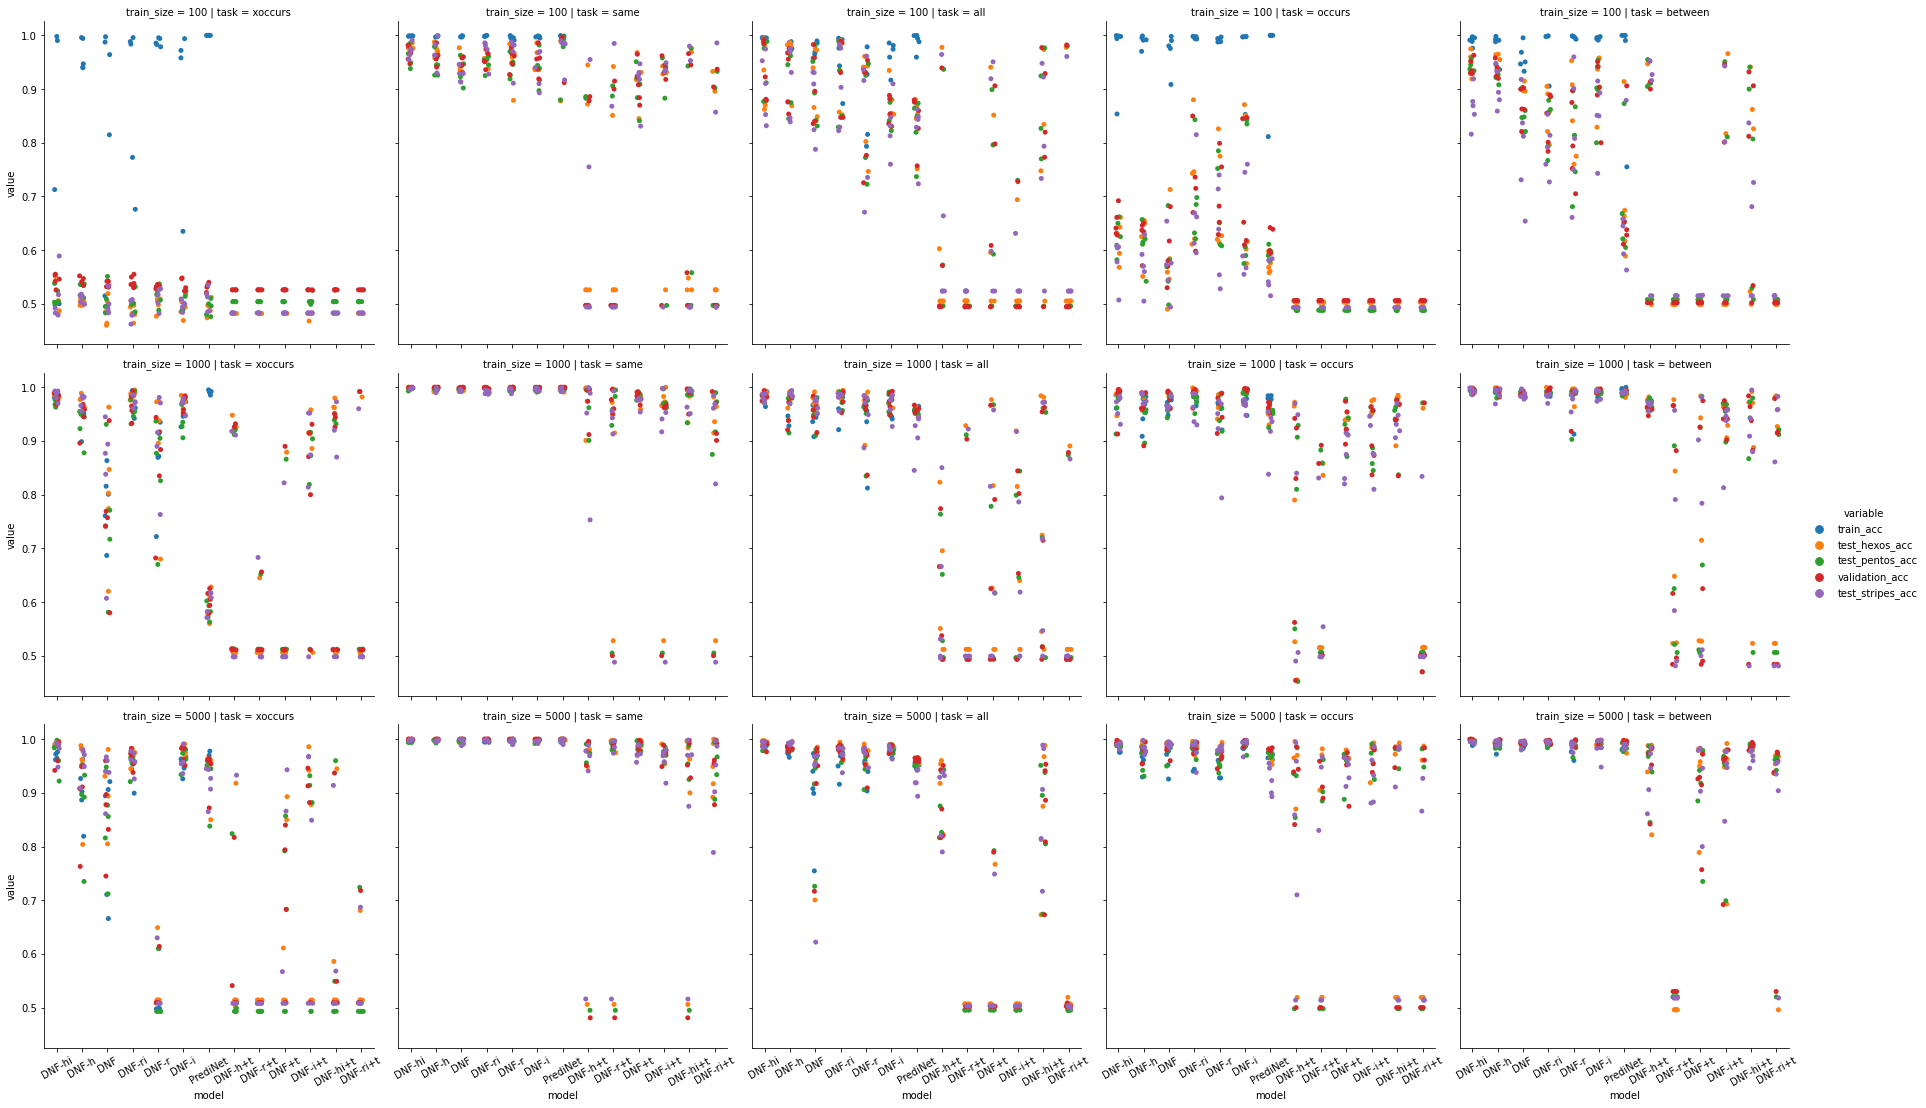

In [10]:
# Time to plot everything (!)
melted_data = pd.melt(all_data, id_vars=['model', 'task', 'train_size'], value_vars=all_data.columns[all_data.columns.str.contains('acc')])
g = sns.catplot(x='model', y='value', hue='variable', col='task', row='train_size', kind='strip', data=melted_data)
g.set_xticklabels(rotation=30)

In [11]:
# What is the overall best DNF model?
dnf_vs_dnf_data = all_data[all_data['model'] != 'PrediNet']
value_cols = all_data.columns[(all_data.columns.str.contains('test') & all_data.columns.str.contains('acc'))]
dnf_vs_dnf_data = dnf_vs_dnf_data.assign(recon=dnf_vs_dnf_data['model'].str.contains('i'), threshold=dnf_vs_dnf_data['model'].str.contains('t'), model=dnf_vs_dnf_data['model'].map(lambda x: x.replace('-i', '').replace('i', '').replace('+t', '')))
pd.pivot_table(dnf_vs_dnf_data, index=[], columns=['model'], values=value_cols, aggfunc=['median'])

median                  
model               DNF   DNF-h     DNF-r
test_hexos_acc    0.948  0.9705  0.890875
test_pentos_acc   0.924  0.9425  0.874375
test_stripes_acc  0.929  0.9515  0.829625

In [12]:
# We will split the above results into more meaningful tables
# First we will compare PrediNet to DNF without image reconstruction
predinet_vs_dnf_data = all_data[~all_data['model'].str.contains(r'-i|hi|ri|\+t')]
pd.pivot_table(predinet_vs_dnf_data, index=['task', 'train_size'], columns=['model'], values=value_cols, aggfunc=['median'])

median                                             \
                   test_hexos_acc                            test_pentos_acc   
model                         DNF    DNF-h    DNF-r PrediNet             DNF   
task    train_size                                                             
all     100               0.93975  0.98125  0.94100   0.8530         0.89275   
        1000              0.97000  0.98850  0.98025   0.9545         0.95725   
        5000              0.97700  0.99225  0.97875   0.9595         0.94600   
between 100               0.89700  0.95500  0.84100   0.6630         0.84800   
        1000              0.98700  0.99700  0.99500   0.9870         0.98600   
        5000              0.99000  0.99300  0.99300   0.9930         0.98900   
occurs  100               0.55900  0.62500  0.62700   0.5680         0.56900   
        1000              0.98900  0.98800  0.98600   0.9540         0.96000   
        5000              0.99400  0.98900  0.98500   0.9660         0.98400   
same    100               0.94200  0.97400  0.95900   0.9880         0.94600   
        1000              0.99700  1.00000  0.99900   0.9970         0.99600   
        5000              0.99600  0.99900  0.99800   0.9980         0.99700   
xoccurs 100               0.48500  0.50400  0.50600   0.4960         0.49700   
        1000              0.80300  0.97800  0.93800   0.5820         0.74200   
        5000              0.93100  0.96200  0.51400   0.9460         0.85600   

                                                                         \
                                              test_stripes_acc            
model                 DNF-h    DNF-r PrediNet              DNF    DNF-h   
task    train_size                                                        
all     100         0.94550  0.92550  0.84925          0.90950  0.93100   
        1000        0.97000  0.96175  0.95550          0.97475  0.98375   
        5000        0.98025  0.96650  0.95500          0.95475  0.99350   
between 100         0.92200  0.81400  0.65100          0.81200  0.89400   
        1000        0.99300  0.99000  0.98800          0.98300  0.99200   
        5000        0.98600  0.98800  0.98300          0.99100  0.99100   
occurs  100         0.61500  0.65100  0.59700          0.57300  0.57000   
        1000        0.95300  0.96100  0.95200          0.96600  0.97400   
        5000        0.97400  0.95600  0.97000          0.99000  0.98500   
same    100         0.94500  0.94600  0.99200          0.92900  0.96300   
        1000        0.99700  0.99600  0.99800          0.99400  0.99500   
        5000        0.99800  0.99700  0.99800          0.99800  0.99700   
xoccurs 100         0.51500  0.51700  0.49600          0.49100  0.51200   
        1000        0.94500  0.87700  0.58200          0.87700  0.98000   
        5000        0.89700  0.49300  0.95100          0.94000  0.97100   

                                      
                                      
model                 DNF-r PrediNet  
task    train_size                    
all     100         0.91600   0.8435  
        1000        0.97150   0.9285  
        5000        0.97625   0.9190  
between 100         0.80800   0.6450  
        1000        0.98600   0.9900  
        5000        0.99000   0.9850  
occurs  100         0.63900   0.5410  
        1000        0.95100   0.9360  
        5000        0.98400   0.9230  
same    100         0.98200   0.9860  
        1000        0.99700   0.9940  
        5000        0.99600   0.9990  
xoccurs 100         0.51700   0.5130  
        1000        0.91600   0.6080  
        5000        0.50800   0.9270

In [13]:
# Does image reconstruction help?
recon_vs_dnf_data = all_data[~all_data['model'].str.contains(r'PrediNet|\+t')]
recon_vs_dnf_data = recon_vs_dnf_data.assign(recon=recon_vs_dnf_data['model'].str.contains('i'), model=recon_vs_dnf_data['model'].map(lambda x: x.replace('-i', '').replace('i', '')))
pd.pivot_table(recon_vs_dnf_data, index=['task', 'train_size'], columns=['recon'], values=value_cols, aggfunc=['median']).T

task                               all                   between         \
train_size                        100      1000     5000    100    1000   
                        recon                                             
median test_hexos_acc   False  0.94100  0.98025  0.98525   0.908  0.994   
                        True   0.88000  0.99000  0.98825   0.919  0.995   
       test_pentos_acc  False  0.92550  0.95825  0.97200   0.867  0.990   
                        True   0.87825  0.98200  0.98150   0.902  0.990   
       test_stripes_acc False  0.91600  0.97550  0.97625   0.859  0.986   
                        True   0.85250  0.98125  0.98250   0.851  0.987   

task                                 occurs                 same         \
train_size                      5000   100    1000   5000   100    1000   
                        recon                                             
median test_hexos_acc   False  0.993  0.621  0.986  0.989  0.960  0.999   
                        True   0.996  0.631  0.993  0.993  0.968  0.999   
       test_pentos_acc  False  0.988  0.611  0.958  0.973  0.945  0.996   
                        True   0.994  0.632  0.982  0.988  0.949  0.996   
       test_stripes_acc False  0.991  0.573  0.969  0.985  0.963  0.995   
                        True   0.995  0.606  0.968  0.990  0.970  0.996   

task                                 xoccurs                
train_size                      5000    100    1000   5000  
                        recon                               
median test_hexos_acc   False  0.998   0.504  0.963  0.894  
                        True   0.999   0.494  0.985  0.982  
       test_pentos_acc  False  0.997   0.514  0.878  0.816  
                        True   0.997   0.499  0.968  0.963  
       test_stripes_acc False  0.997   0.503  0.945  0.938  
                        True   0.998   0.494  0.973  0.962

In [14]:
# What happens when we threshold?
threshold_vs_dnf_data = all_data[~all_data['model'].str.contains(r'PrediNet')]
threshold_vs_dnf_data = threshold_vs_dnf_data.assign(recon=threshold_vs_dnf_data['model'].str.contains('i'), threshold=threshold_vs_dnf_data['model'].str.contains('t'), model=threshold_vs_dnf_data['model'].map(lambda x: x.replace('-i', '').replace('i', '').replace('+t', '')))
pd.pivot_table(threshold_vs_dnf_data, index=['task', 'train_size'], columns=['model', 'threshold'], values=value_cols, aggfunc=['median'])

median                                         \
                   test_hexos_acc                                          
model                         DNF              DNF-h               DNF-r   
threshold                   False    True      False     True      False   
task    train_size                                                         
all     100              0.872875  0.50525  0.958375  0.675250  0.937625   
        1000             0.977875  0.63300  0.989750  0.623125  0.987000   
        5000             0.982875  0.50675  0.993750  0.896375  0.982000   
between 100              0.901500  0.49900  0.952500  0.844000  0.849000   
        1000             0.993000  0.93600  0.995500  0.972500  0.995000   
        5000             0.991000  0.96050  0.997000  0.983500  0.994000   
occurs  100              0.593000  0.50300  0.628000  0.503000  0.685000   
        1000             0.990500  0.95250  0.988000  0.967000  0.986500   
        5000             0.993500  0.97550  0.993000  0.967500  0.986500   
same    100              0.941000  0.92900  0.976500  0.537000  0.958000   
        1000             0.998000  0.97950  0.999000  0.993500  0.998500   
        5000             0.997000  0.97900  0.998500  0.972000  0.998000   
xoccurs 100              0.489500  0.48200  0.503000  0.482000  0.495500   
        1000             0.961500  0.69250  0.983500  0.717500  0.975000   
        5000             0.964000  0.73050  0.988500  0.514000  0.797000   

                                                                          \
                            test_pentos_acc                                
model                                   DNF              DNF-h             
threshold             True            False    True      False     True    
task    train_size                                                         
all     100         0.50525        0.858375  0.49575  0.928625  0.671125   
        1000        0.51175        0.957750  0.63125  0.978750  0.589750   
        5000        0.50675        0.975375  0.49550  0.987625  0.885500   
between 100         0.49900        0.879500  0.50800  0.932500  0.853500   
        1000        0.74600        0.987500  0.94000  0.993000  0.968000   
        5000        0.49600        0.990500  0.94700  0.994500  0.982500   
occurs  100         0.50300        0.586000  0.48800  0.618000  0.488000   
        1000        0.51500        0.984000  0.92150  0.960000  0.918000   
        5000        0.71200        0.985500  0.96100  0.983500  0.934000   
same    100         0.52600        0.941500  0.91500  0.947000  0.527500   
        1000        0.94300        0.995500  0.97750  0.997000  0.986000   
        5000        0.98350        0.997500  0.97950  0.997500  0.965000   
xoccurs 100         0.48200        0.496000  0.50400  0.514500  0.504000   
        1000        0.50600        0.916500  0.66550  0.959000  0.712500   
        5000        0.51400        0.941000  0.73750  0.942500  0.493000   

                                                                           \
                                      test_stripes_acc                      
model                  DNF-r                       DNF              DNF-h   
threshold              False    True             False    True      False   
task    train_size                                                          
all     100         0.928125  0.49575         0.839625  0.52375  0.920750   
        1000        0.967375  0.49650         0.975125  0.61800  0.983625   
        5000        0.972875  0.49550         0.968500  0.50325  0.993125   
between 100         0.834500  0.50800         0.843500  0.51500  0.878500   
        1000        0.990000  0.75800         0.986000  0.92000  0.993500   
        5000        0.990000  0.52000         0.987500  0.95100  0.995000   
occurs  100         0.668000  0.48800         0.574500  0.49300  0.585000   
        1000        0.970500  0.50600         0.967000  0.876

## Analyse Run Report
We can pick a single run and analyse the reports such as attention maps and the rules it has learned.

In [313]:
filter_dict = {'model': 'DNF-i', 'task': 'between', 'train_size': 1000}
is_recon = 'i' in filter_dict['model']
utils.analysis.filter_by_dict(exp_data, filter_dict)['run_id'].unique()

array(['74a6a8efe2bf44b4968936118d923553', '198b5b5120a641ec965e37990c186322', '45aec1248e864245a4827fec0b138530',
       'e5604c0d64fe4209aedc4c11850b6b2e', 'f3ed8f0bdb104981b87f49fbc566c4b6'], dtype=object)

In [303]:
# Gather a specific run
run_id = "74a6a8efe2bf44b4968936118d923553"
print("Collecting artifacts for run:", run_id)
mlrun = mlclient.get_run(run_id)
pprint(mlrun.to_dictionary())
pprint(mlclient.list_artifacts(run_id))

{'data': {'metrics': {'epoch': 149.0,
                      'test_hexos_loss': 0.055323243141174316,
                      'test_hexos_nullary_acc': 0.9869999885559082,
                      'test_hexos_nullary_loss': 0.04520971328020096,
                      'test_hexos_recon_loss': 0.010113529860973358,
                      'test_hexos_recon_mae': 0.033637311309576035,
                      'test_pentos_loss': 0.08688268065452576,
                      'test_pentos_nullary_acc': 0.9850000143051147,
                      'test_pentos_nullary_loss': 0.08255814760923386,
                      'test_pentos_recon_loss': 0.004324520472437143,
                      'test_pentos_recon_mae': 0.01393863558769226,
                      'test_stripes_loss': 0.26371392607688904,
                      'test_stripes_nullary_acc': 0.9760000109672546,
                      'test_stripes_nullary_loss': 0.12706130743026733,
                      'test_stripes_recon_loss': 0.1366526484489441,
        

In [304]:
def load_report(run_id: str, fpath: str):
    """Load numpy compressed report from given artifact."""
    local_path = mlclient.download_artifacts(run_id, fpath)
    return np.load(local_path)

report = load_report(run_id, "test_hexos_report.npz")
print(report.files)

['in_image', 'out_image', 'out_label', 'object_sel_object_scores', 'object_sel_object_atts', 'object_sel_objects', 'report_layer_unary', 'report_layer_binary', 'report_layer_nullary', 'facts0_nullary', 'facts0_unary', 'facts0_binary', 'facts0_or_kernel', 'facts0_conjuncts', 'facts0_and_kernel', 'recon_combined', 'recon_recon_masks', 'recon_reconstructions', 'prediction_image', 'prediction_label']


In [305]:
# Let's pick some examples to analyse
#labels = np.argmax(report['out_label'], -1)
labels = report['out_label']
predictions = report['prediction_label'][:, 0] > 0
idxs = np.flatnonzero(labels != predictions)[:8]
idxs = np.arange(8)
print(idxs)
print(np.stack([labels[idxs], predictions[idxs]]))
print(report['prediction_label'][idxs])

[0 1 2 3 4 5 6 7]
[[1 1 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 1]]
[[10.02874]
 [ 3.92316]
 [-6.70018]
 [-6.60398]
 [-6.24817]
 [-3.67877]
 [ 6.6629 ]
 [ 9.82674]]


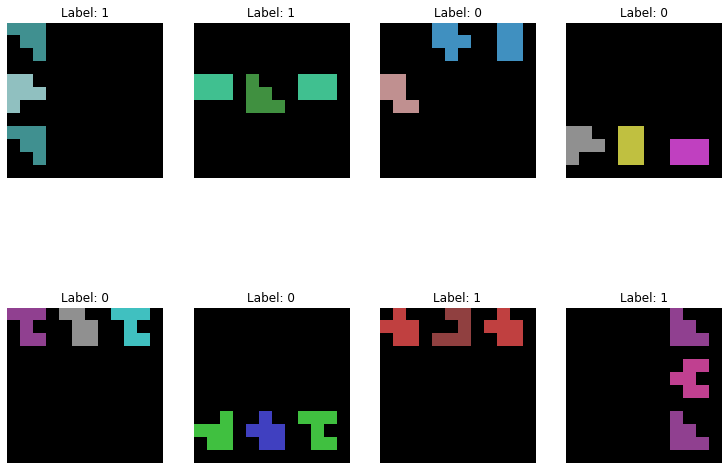

In [306]:
def plot_image(data: Dict[str, np.ndarray]):
    """Plot single image data point."""
    # data {'image': (W, H, C), 'task_id': (), 'label': ()}
    plt.imshow(np.clip((data['in_image']+1)/2, 0, 1))
    if 'out_label' in data:
        title = f"Label: {data['out_label']}"       
        if 'in_task_id' in data:
            title = f"Task: {data['in_task_id']} - " + title
        plt.title(title)
    plt.axis("off")

utils.analysis.plot_batch({k: report[k][idxs] for k in ['in_image', 'in_task_id', 'out_label'] if k in report}, plot_image, size=8)

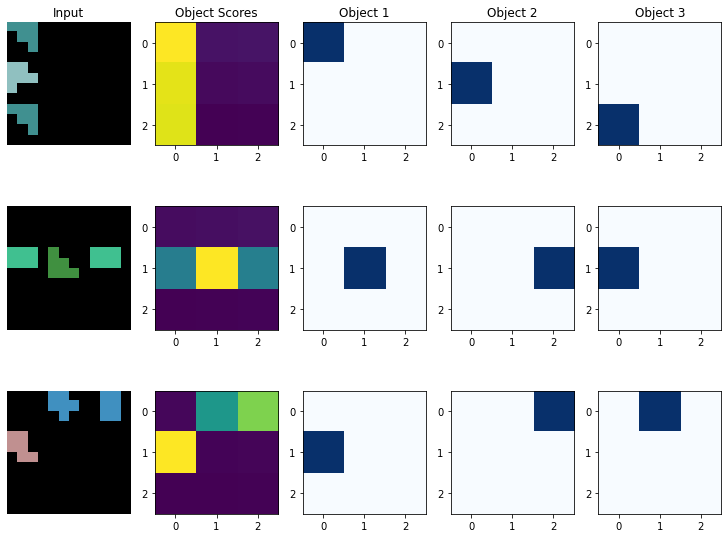

In [307]:
# Which image patches have been selected as objects?
def plot_obj_attention(report, indices):
    """Plot object attention maps."""
    # Determine how many objects there are
    example_att = report['object_sel_object_atts'][indices[0]].reshape(-1, 3, 3)
    num_objects = example_att.shape[0] # O
    rows = len(indices)
    cols = num_objects + 2
    # Setup figure
    plt.figure(figsize=(12.8, 9.6))
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i*cols+1)
        plt.imshow(np.clip((report['in_image'][idx]+1)/2, 0, 1))
        plt.axis('off')
        if i == 0:
            plt.title("Input")
        plt.subplot(rows, cols, i*cols+2)
        plt.imshow(report['object_sel_object_scores'][idx].reshape(3, 3), cmap='viridis')
        plt.yticks(range(3))
        plt.xticks(range(3))
        if i == 0:
            plt.title("Object Scores")
        for j in range(num_objects):
            plt.subplot(rows, cols, i*cols + j + 3)
            att_map = report['object_sel_object_atts'][idx].reshape(-1, 3, 3)[j]
            plt.imshow(att_map, cmap='Blues')
            plt.yticks(range(3))
            plt.xticks(range(3))
            if i == 0:
                plt.title(f"Object {j+1}")

plot_obj_attention(report, idxs[:3])

In [308]:
# Analyse the learnt program and predicates
print("The accuracy of the thresholded model is")
pruning_with_metadata.loc[run_id]

The accuracy of the thresholded model is


test_hexos_acc        0.906
test_stripes_acc      0.813
test_pentos_acc       0.898
validation_acc        0.902
train_size             1000
task                between
run_count                 4
model               DNF-i+t
Name: 74a6a8efe2bf44b4968936118d923553, dtype: object

In [314]:
# But what has it learnt as the final rule?
# Load pruning info json back
pruning_info = utils.analysis.load_artifact(run_id, 'pruning_info.json', mlclient)
# First let's look at the different steps of pruning
def print_kernel_steps(kernel_name: str, pinfo, print_kernel: bool = True):
    """Print the steps of the pruning."""
    pruning_steps = ['preprune', 'pruned', 'threshold', 'threshold_pruned']
    for step in pruning_steps:
        if print_kernel:
            print(kernel_name, step)
            kernel = np.array(pinfo[kernel_name + '.' + step])
            print(kernel[0].round(2))
        acc_key = kernel_name + '.' + 'test_pentos_' + step + '_nullary_acc' if is_recon else '_acc'
        print(acc_key, pinfo[acc_key])
print_kernel_steps('dnf_layer.or_kernel', pruning_info)
print_kernel_steps('dnf_layer.and_kernel', pruning_info, print_kernel=False)

dnf_layer.or_kernel preprune
[-0.65  0.96 -2.3  -1.68 -1.96 -0.27 -7.63 -2.02]
dnf_layer.or_kernel.test_pentos_preprune_nullary_acc 0.9860000014305115
dnf_layer.or_kernel pruned
[-0.65  0.96 -2.3  -1.68 -1.96 -0.27 -7.63 -2.02]
dnf_layer.or_kernel.test_pentos_pruned_nullary_acc 0.9779999852180481
dnf_layer.or_kernel threshold
[-0.  0. -6. -0. -0. -0. -6. -6.]
dnf_layer.or_kernel.test_pentos_threshold_nullary_acc 0.9599999785423279
dnf_layer.or_kernel threshold_pruned
[-0.  0. -6. -0. -0. -0. -0. -6.]
dnf_layer.or_kernel.test_pentos_threshold_pruned_nullary_acc 0.9620000123977661
dnf_layer.and_kernel.test_pentos_preprune_nullary_acc 0.9670000076293945
dnf_layer.and_kernel.test_pentos_pruned_nullary_acc 0.968999981880188
dnf_layer.and_kernel.test_pentos_threshold_nullary_acc 0.9150000214576721
dnf_layer.and_kernel.test_pentos_threshold_pruned_nullary_acc 0.8980000019073486


In [315]:
rule_kernels = {
    'and_kernel': np.array(pruning_info['dnf_layer.and_kernel.threshold_pruned'])[0]/6,
    'or_kernel': np.array(pruning_info['dnf_layer.or_kernel.threshold_pruned'])[0]/6,
    'num_variables': int(mlrun.to_dictionary()['data']['params']['dnf_image_classifier_inference_num_total_variables'])
}
# The following is just used for getting the size of the rule
interpretation = {k: report['report_layer_'+k] for k in ['nullary', 'unary', 'binary']}
learnt_rules = utils.clingo.tensor_rule_to_strings(interpretation, rule_kernels)
learnt_rules

['t :- not c2.',
 'c2 :- not binary(V1,V2,0), binary(V2,V0,14), binary(V2,V1,0), obj(V2), V2 != V1, V2 != V0, obj(V1), V1 != V0, obj(V0).',
 't :- not c7.',
 'c7 :- binary(V0,V1,14), binary(V2,V1,12), obj(V2), V2 != V1, V2 != V0, obj(V1), V1 != V0, obj(V0).']

In [316]:
# For an absolute sanity check, let's run the output of the neural network through clingo
threshold_interpretation = {k: (v > 0)*2-1 for k, v in interpretation.items()}
result = utils.clingo.clingo_rule_check(threshold_interpretation, learnt_rules)
(result == report['out_label']).mean()

100%|██████████| 64/64 [00:01<00:00, 54.21it/s]


0.9375

In [317]:
# Let's gather the predicates that appear in the rule
binary_idxs = list({int(i) for lr in learnt_rules for i in re.findall(r'binary\(V\d,V\d,(\d+)\)', lr)})
print(binary_idxs)

[0, 12, 14]


In [318]:
# Let's extract out the objects
num_objects = interpretation['unary'].shape[1]
full_obj_mask = report['object_sel_object_atts'].reshape(64, num_objects, 3, 3)
full_obj_mask = np.repeat(full_obj_mask, 4, axis=3)
full_obj_mask = np.repeat(full_obj_mask, 4, axis=2) # (B, O, W, H)
full_objs = np.expand_dims(np.clip((report['in_image']+1)/2, 0, 1), 1) * np.expand_dims(full_obj_mask, -1) # (B, O, W, H, C)

[[-1.      -0.99999]
 [-0.99996 -0.99995]
 [-1.      -1.     ]]
[[-0.99925 -0.81915]
 [ 0.85878  0.86619]
 [-0.78102 -0.99902]]
[10.02874]
1


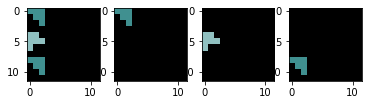

In [319]:
# Take some positive and negative examples to analyse
example_id = 0
plt.subplot(1, 4, 1)
plt.imshow(full_objs[example_id].sum(0))
plt.subplot(1, 4, 2)
plt.imshow(full_objs[example_id, 0])
plt.subplot(1, 4, 3)
plt.imshow(full_objs[example_id, 1])
plt.subplot(1, 4, 4)
plt.imshow(full_objs[example_id, 2])
print(interpretation['binary'][example_id][..., 10])
print(interpretation['binary'][example_id][..., 14])
print(report['prediction_label'][example_id])
print(report['out_label'][example_id])

In [320]:
report['object_sel_objects'][0]

array([[4.0405 , 0.     , 4.72719, 0.     , 0.29884, 4.11462, 0.     , 0.     , 3.32337, 1.16854, 0.     , 1.10788,
        3.59479, 0.     , 1.14776, 4.14868, 4.2025 , 0.     , 0.     , 0.99384, 4.27975, 4.32373, 0.09336, 0.     ,
        0.45119, 0.     , 1.27546, 0.     , 3.74339, 0.63578, 0.     , 0.     , 0.     , 0.     , 1.     , 1.     ],
       [4.06702, 0.     , 4.39109, 0.     , 0.11833, 4.45108, 0.     , 0.     , 2.97398, 0.28609, 0.     , 1.23684,
        3.76294, 0.     , 2.44192, 3.52417, 3.7515 , 0.     , 0.     , 0.48724, 4.64081, 4.25805, 0.     , 0.     ,
        0.27939, 0.     , 2.57793, 0.     , 3.59748, 0.     , 0.     , 0.     , 0.5    , 0.     , 0.5    , 1.     ],
       [4.0405 , 0.     , 4.72719, 0.     , 0.29884, 4.11462, 0.     , 0.     , 3.32337, 1.16854, 0.     , 1.10788,
        3.59479, 0.     , 1.14776, 4.14868, 4.2025 , 0.     , 0.     , 0.99384, 4.27975, 4.32373, 0.09336, 0.     ,
        0.45119, 0.     , 1.27546, 0.     , 3.74339, 0.63578, 0.     ,

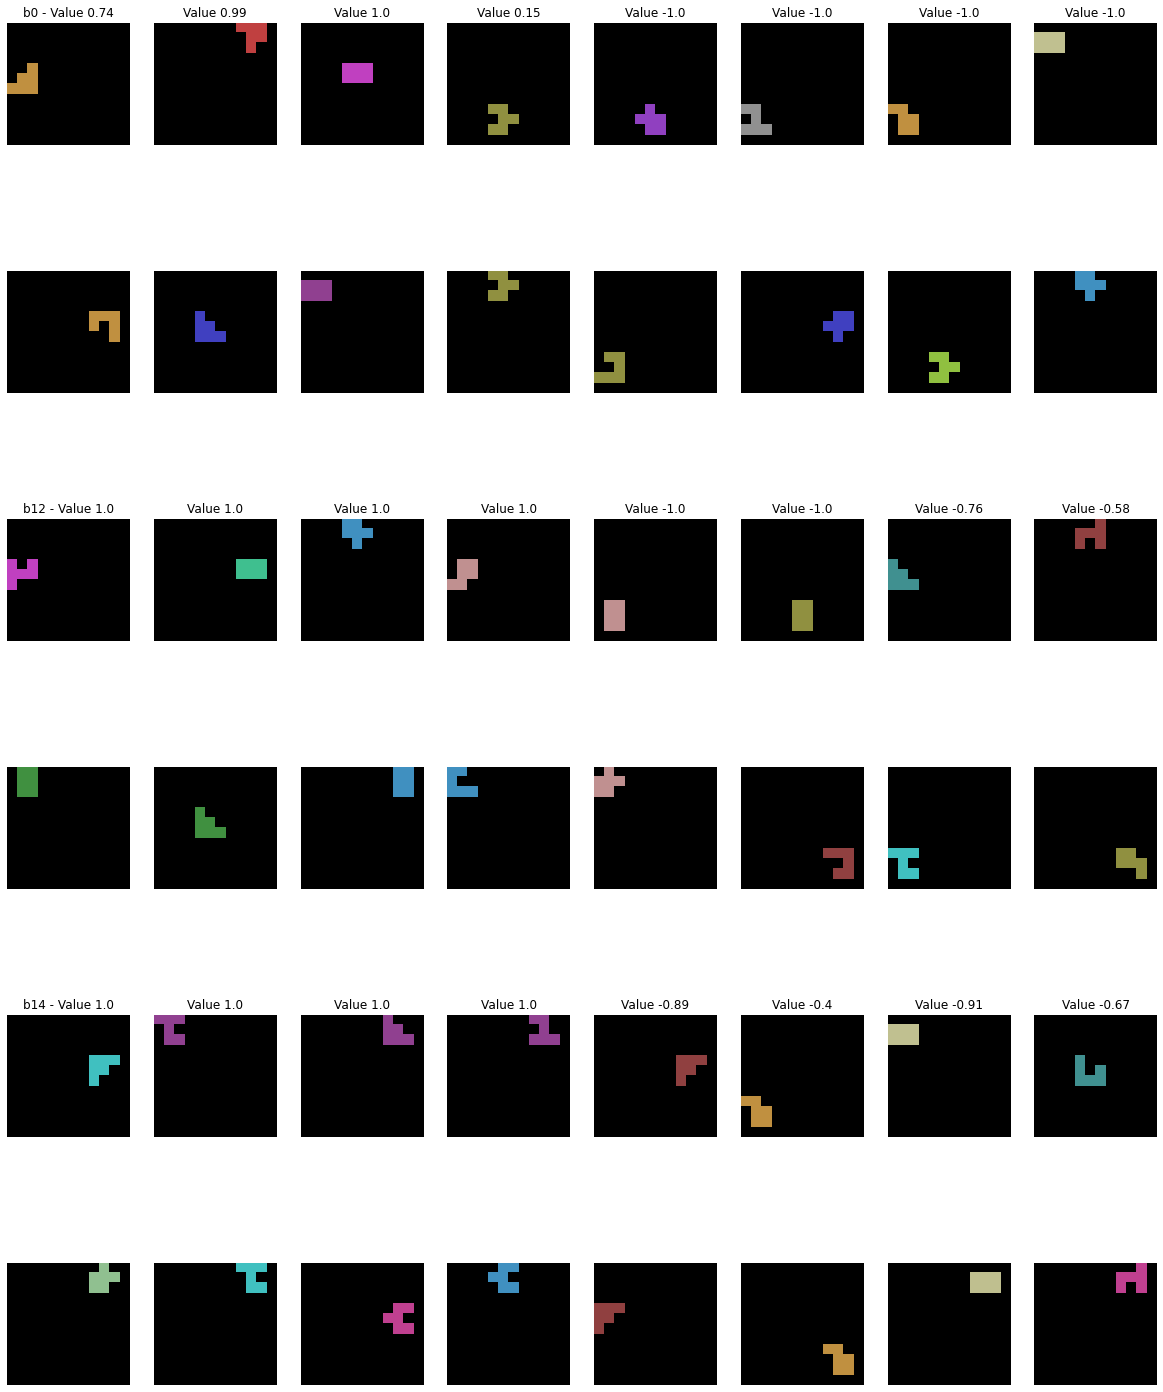

In [322]:
per_case_num = 4
fig, axes = plt.subplots(len(binary_idxs)*2, per_case_num*2, figsize=(20.6, 26.6))
for i, bidx in enumerate(binary_idxs):
    # Find examples where they are true and false
    facts = interpretation['binary'][..., bidx] > 0
    pos_cases = np.stack(np.nonzero(facts), 1) # (N, 3)
    np.random.shuffle(pos_cases) # (N, 3)
    pos_cases = pos_cases[:per_case_num] # (4, 3)
    neg_cases = np.stack(np.nonzero(np.logical_not(facts)), 1) # (M, 3)
    np.random.shuffle(neg_cases) # (M, 3)
    neg_cases = neg_cases[:per_case_num] # (4, 3)
    cases = np.concatenate([pos_cases, neg_cases], axis=0) # (8, 3)
    # Plot the objects with the value
    for j, (batch_id, obj1_id, obj2_id) in enumerate(cases):
        # case (batch, obj1, obj2)
        value = interpretation['binary'][batch_id, obj1_id, obj2_id, bidx]
        obj1_img = full_objs[batch_id, obj1_id] # (W, H, C)
        # The second object index is skewed because p(X,X) is missing, it is O*(O-1)
        obj2_img = full_objs[batch_id, obj2_id + (obj2_id >= obj1_id)] # (W, H, C)
        axes[i*2, j].imshow(obj1_img)
        axes[i*2, j].axis('off')
        title = "Value " + str(round(value, 2))
        if j == 0:
            title = f"b{bidx} - " + title
        axes[i*2, j].set_title(title)
        axes[i*2+1, j].imshow(obj2_img)
        axes[i*2+1, j].axis('off')

# Analayse Image Reconstruction
Plot image reconstruction from DNF-i models.

In [323]:
report.files

['in_image',
 'out_image',
 'out_label',
 'object_sel_object_scores',
 'object_sel_object_atts',
 'object_sel_objects',
 'report_layer_unary',
 'report_layer_binary',
 'report_layer_nullary',
 'facts0_nullary',
 'facts0_unary',
 'facts0_binary',
 'facts0_or_kernel',
 'facts0_conjuncts',
 'facts0_and_kernel',
 'recon_combined',
 'recon_recon_masks',
 'recon_reconstructions',
 'prediction_image',
 'prediction_label']

In [326]:
report['recon_reconstructions'].shape

(64, 3, 12, 12, 3)

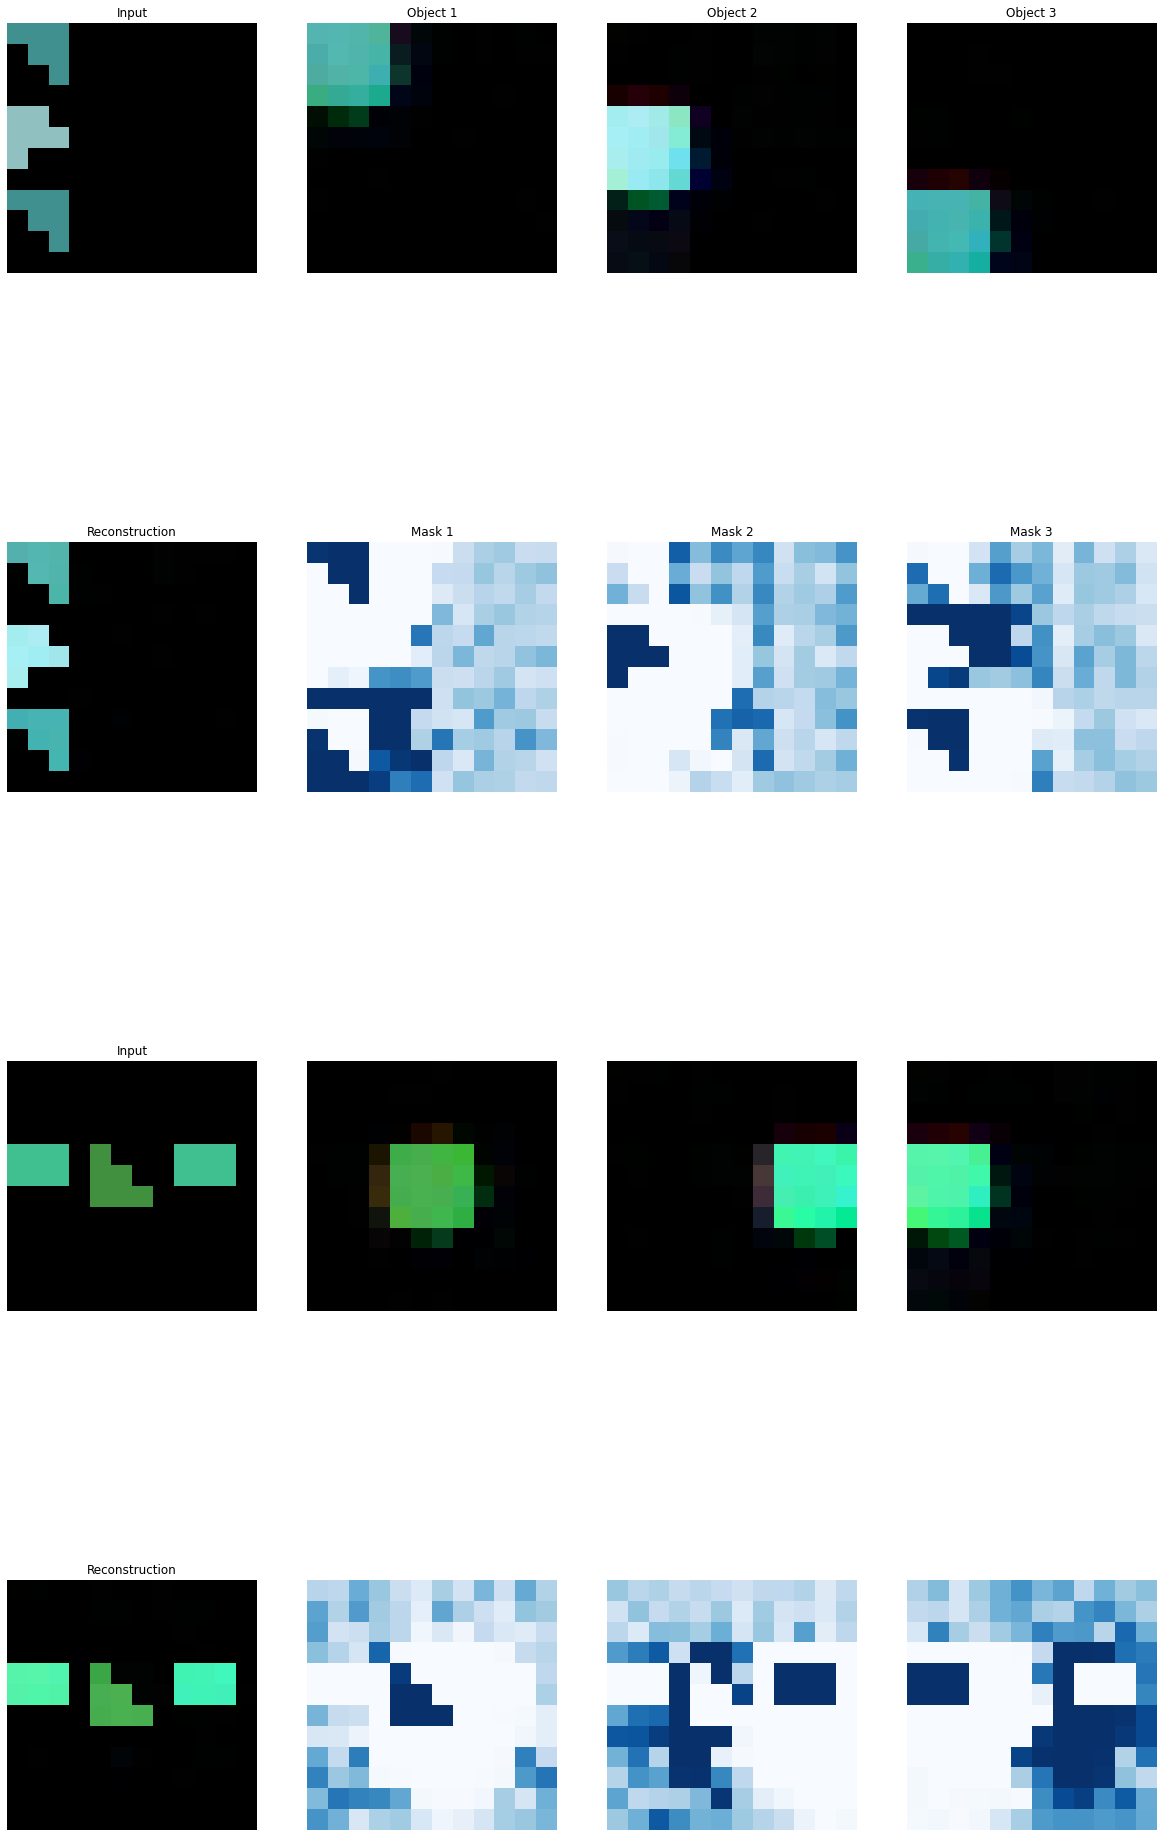

In [338]:
def plot_reconstructions(indices):
    """Plot reconstruction of DNF-i models."""
    num_objects = report['report_layer_unary'].shape[1] # O
    fig, axes = plt.subplots(len(indices)*2, num_objects+1, figsize=(20.6, 36.6))
    for i, bidx in enumerate(indices):
        combined = np.clip((report['recon_combined'][bidx]+1)/2, 0, 1) # (W, H, C)
        masks = report['recon_recon_masks'][bidx, ..., 0] # (O, W, H)
        obj_recons = np.clip((report['recon_reconstructions'][bidx]+1)/2, 0, 1) # (O, W, H, C)
        # Plot input and full reconstruction
        axes[i*2, 0].imshow(np.clip((report['in_image'][bidx]+1)/2, 0, 1))
        axes[i*2, 0].axis('off')
        axes[i*2, 0].set_title('Input')
        axes[i*2+1, 0].imshow(combined)
        axes[i*2+1, 0].axis('off')
        axes[i*2+1, 0].set_title('Reconstruction')
        # Plot the objects and masks
        for j in range(num_objects):
            axes[i*2, j+1].imshow(obj_recons[j])
            axes[i*2, j+1].axis('off')
            axes[i*2+1, j+1].imshow(masks[j], cmap='Blues')
            axes[i*2+1, j+1].axis('off')
            if i == 0:
                axes[i*2, j+1].set_title(f"Object {j+1}")
                axes[i*2+1, j+1].set_title(f"Mask {j+1}")
if is_recon:
    plot_reconstructions(idxs[:2])